In [1]:
# Import statements
import xarray as xr
from scipy.ndimage import gaussian_filter
import cartopy.crs as ccrs
from metpy.plots import ctables
import numpy as np
from xskillscore import resample_iterations_idx
from dask.diagnostics.progress import ProgressBar
import dask
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.feature as cfeature
from typing import List
import matplotlib.patches as patches

plt.style.use("dark_background")
mpl.rcParams["hatch.linewidth"] = 0.2

In [15]:
# Define functions
def get_wofs_all(init: int) -> xr.Dataset:
    """Read in WoFS output based on initialization time."""
    file_pattern = f"/mnt/drive2/new-wofs/{init:02d}Z/wofs_ALL*.nc"
    loaded = xr.open_mfdataset(
        file_pattern, combine="nested", concat_dim="time", chunks="auto"
    )

    if init < 6:
        start_time = f"2021-09-02 {init:02d}:00:00"
        end_time = f"2021-09-02 {init + 6:02d}:00:00"
    else:
        start_time = f"2021-09-01 {init:02d}:00:00"
        end_time = f"2021-09-02 {init - 24 + 6:02d}:00:00"

    loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
    return loaded


def overwrite_ne(da: xr.DataArray | xr.Dataset) -> xr.DataArray | xr.Dataset:
    """Overwrite 'ne' values in the DataArray or Dataset."""
    da["ne"] = range(5)
    return da


def smooth(da: xr.DataArray, sigma: int = 3, axes: tuple = (1, 2)) -> xr.DataArray:
    """Apply Gaussian smoothing to the DataArray."""
    smoothed_da = da.copy()
    smoothed_da.values = gaussian_filter(da.values, sigma=sigma, axes=axes)
    smoothed_da = smoothed_da.assign_attrs(da.attrs)
    return smoothed_da


def stack_and_chunk(data_arrays, dim_name, chunk_size):
    """Concatenate, stack, and chunk the given data arrays."""
    return (
        xr.concat(data_arrays, dim=dim_name)
        .stack(run=(dim_name, "ne"))
        .chunk({"run": chunk_size})
    )


def process_variable(
    wofs_list: List[xr.Dataset], var_name: str, overwrite: bool = False
) -> xr.DataArray:
    """Process a variable data with optional 'ne' overwrite."""
    data_arrays = [
        overwrite_ne(getattr(ds, var_name)) if overwrite else getattr(ds, var_name)
        for ds in wofs_list
    ]
    return stack_and_chunk(data_arrays, "init", "auto" if overwrite else -1)


def process_and_smooth(data, times, smooth_data=True, sigma=5):
    """Process and optionally smooth data for selected times."""
    selected_data = xr.concat(
        [data.sel(time=time).squeeze() for time in times], dim="time"
    ).compute()
    if smooth_data:
        if isinstance(selected_data, xr.Dataset):
            # Apply smoothing to each variable in the Dataset
            smoothed_data = selected_data.map_blocks(
                lambda ds: ds.map(lambda x: smooth(x, sigma=sigma))
            )
            smoothed_data = smoothed_data.assign_attrs(data.attrs)
        elif isinstance(selected_data, xr.DataArray):
            smoothed_data = smooth(selected_data, sigma=sigma)
        return smoothed_data
    return selected_data


# Function to perform resampling and compute means
def resample_and_compute_means(
    data, time, lat_chunk=50, lon_chunk=50, iterations=1000, dim_max=20
):
    chunked_data = (
        data.sel(time=time).squeeze().chunk({"lat": lat_chunk, "lon": lon_chunk})
    )
    set1 = resample_iterations_idx(
        chunked_data, iterations, dim="run", replace=False, dim_max=dim_max
    ).mean(dim="run")
    set2 = resample_iterations_idx(
        chunked_data, iterations, dim="run", replace=False, dim_max=dim_max
    ).mean(dim="run")
    return set1, set2


# Function to compute differences and quantiles
def compute_difference_and_quantiles(set1, set2):
    return (set1 - set2).quantile([0.05, 0.95], dim="iteration").compute()


# Compute masks
def compute_mask(diff, results):
    return (diff < results.sel(quantile=0.05).squeeze()) | (
        diff > results.sel(quantile=0.95).squeeze()
    )


def process_theta(
    wofs_list, temp_var: str, pressure_var: str = None, overwrite=False
) -> xr.DataArray:
    """Process temperature data and calculate potential temperature.

    Parameters:
    - wofs_list: List of xarray Datasets containing the WoFS data.
    - temp_var: The name of the temperature variable (e.g., 't_2', 'temperature_700').
    - pressure_var: The name of the pressure variable (if different from a constant pressure level).
    - overwrite: Whether to overwrite the 'ne' dimension (default is False).

    Returns:
    - theta: Potential temperature (xarray.DataArray)
    """
    # Read in the specified temperature variable
    temperature = process_variable(wofs_list, temp_var, overwrite)

    # Convert temperature if it is in Fahrenheit (assuming t_2 is the only Fahrenheit temperature)
    if temp_var == "t_2":
        temperature = (temperature - 32) * (5 / 9)  # Convert to Celsius

    # Determine the pressure
    if pressure_var:
        pressure = process_variable(wofs_list, pressure_var, overwrite)
    else:
        # Use a constant pressure level if no pressure variable is provided
        pressure = xr.full_like(
            temperature, 1000
        )  # Default to 1000 hPa, adjust as necessary

    # Calculate potential temperature
    theta = calc_theta(temperature, pressure)
    return theta


def calc_theta(T: xr.DataArray, p: xr.DataArray) -> xr.DataArray:
    """Calculate potential temperature in Kelvin.

    Parameters:
    - T: Temperature in Celsius (xarray.DataArray)
    - p: Pressure in hPa (xarray.DataArray)

    Returns:
    - theta: Potential temperature in Kelvin (xarray.DataArray)
    """
    # Convert temperature to Kelvin
    T_k = T + 273.15

    # Calculate potential temperature (theta)
    theta = T_k * ((1000 / p) ** 0.286)

    # Set the name and units
    theta.name = "theta"
    theta.attrs["units"] = "K"

    return theta

def process_and_select_theta(wofs_list, temp_var: str, times, pressure_var: str = None, overwrite=False) -> xr.DataArray:
    """Process temperature data, calculate potential temperature, and select specific times.

    Parameters:
    - wofs_list: List of xarray Datasets containing the WoFS data.
    - temp_var: The name of the temperature variable (e.g., 't_2', 'temperature_700').
    - times: List of times to select (e.g., ["2021-09-01 23:00:00", "2021-09-02 00:00:00"]).
    - pressure_var: The name of the pressure variable (if different from a constant pressure level).
    - overwrite: Whether to overwrite the 'ne' dimension (default is False).

    Returns:
    - selected_theta: Potential temperature for the selected times (xarray.DataArray)
    """
    # Process temperature data and calculate potential temperature
    theta = process_theta(wofs_list, temp_var, pressure_var, overwrite)

    # Select the desired times using xr.concat and list comprehension
    selected_theta = xr.concat([theta.sel(time=time) for time in times], dim="time")
    return selected_theta

def process_and_select_winds(wofs_list, u_var: str, v_var: str, times, overwrite=False) -> xr.Dataset:
    """Process wind data and select specific times.

    Parameters:
    - wofs_list: List of xarray Datasets containing the WoFS data.
    - u_var: The name of the zonal wind variable (e.g., 'u_10', 'U_700').
    - v_var: The name of the meridional wind variable (e.g., 'v_10', 'V_700').
    - times: List of times to select (e.g., ["2021-09-01 23:00:00", "2021-09-02 00:00:00"]).
    - overwrite: Whether to overwrite the 'ne' dimension (default is False).

    Returns:
    - selected_winds: Dataset containing the zonal and meridional wind components for the selected times (xarray.Dataset)
    """
    # Process the zonal and meridional wind components
    u_wind = process_variable(wofs_list, u_var, overwrite)
    v_wind = process_variable(wofs_list, v_var, overwrite)

    # Combine the wind components into a single Dataset
    winds = xr.Dataset({u_var: u_wind, v_var: v_wind})

    # Select the desired times using xr.concat and list comprehension
    selected_winds = xr.concat([winds.sel(time=time) for time in times], dim="time")
    
    return selected_winds

def set_lat_lon(dataarrays, step=3000, size=900000):
    """Set lat/lon values."""
    for da in dataarrays:
        da["lat"] = range(0, size, step)
        da["lon"] = range(0, size, step)


def calculate_gradient(theta):
    """Calculate gradients along x and y."""
    grad_x = theta.differentiate("lon")
    grad_y = theta.differentiate("lat")
    return grad_x, grad_y

In [3]:
# Read in WoFS initializations 20–23Z
wofs_all = [get_wofs_all(i) for i in [20,21,22,23]]

In [4]:
# Define variables and parameters
lat = wofs_all[0].xlat.isel(time=0).squeeze().drop_vars("time")
lon = wofs_all[0].xlon.isel(time=0).squeeze().drop_vars("time")

# Set up Cartopy projection
proj = ccrs.LambertConformal(
    central_longitude=wofs_all[0].attrs["CEN_LON"],
    central_latitude=wofs_all[0].attrs["CEN_LAT"],
    standard_parallels=(30, 60),
)  # WoFS projection

# Get MetPy colortables
precip_cmap = ctables.registry.get_colortable("precipitation")
refl_cmap = ctables.registry.get_colortable("NWSReflectivity")

# Create a DataArray for the initialization dimension
init = xr.DataArray(data=["20Z", "21Z", "22Z", "23Z"], dims="init").assign_coords(
    {"init": ["20Z", "21Z", "22Z", "23Z"]}
)

## Create wet & dry ensembles

In [5]:
# Set desired latitude and longitude (Central Park)
nyc_lat, nyc_lon = 40.7826, -73.9656

# Calculate Euclidean distance and find the nearest indices
distance = np.sqrt((lat - nyc_lat) ** 2 + (lon - nyc_lon) ** 2)
nyc_inds = distance.argmin(dim=["NY", "NX"])
lat_ind, lon_ind = int(nyc_inds["NY"]), int(nyc_inds["NX"])

# Sort by Central Park precipitation
rain_nyc_0102 = [
    w.rain.isel(lat=lat_ind, lon=lon_ind)
    .sel(time=slice("2021-09-02 01:05:00", "2021-09-02 02:00:00"))
    .sum(dim="time")
    .squeeze()
    for w in wofs_all
]

# Get indices of wettest and driest ensemble members
ne_wet = [
    r.ne.where(r > r.quantile(0.75, dim="ne")).dropna(dim="ne") for r in rain_nyc_0102
]
ne_dry = [
    r.ne.where(r < r.quantile(0.25, dim="ne")).dropna(dim="ne") for r in rain_nyc_0102
]

# Select wet and dry members
wofs_wet = [
    w.sel(ne=ne_wet[i].astype(int)).drop_vars("quantile")
    for i, w in enumerate(wofs_all)
]
wofs_dry = [
    w.sel(ne=ne_dry[i].astype(int)).drop_vars("quantile")
    for i, w in enumerate(wofs_all)
]

### Read in variables

In [22]:
# Select times
times = ["2021-09-01 23:00:00", "2021-09-02 00:00:00"]

# Process temperature data
theta2m_all = process_and_select_theta(wofs_all, "t_2", times, "psfc")
theta2m_wet = process_and_select_theta(wofs_wet, "t_2", times, "psfc", overwrite=True)
theta2m_dry = process_and_select_theta(wofs_dry, "t_2", times, "psfc", overwrite=True)

uv10m_all = process_and_select_winds(wofs_all, "u_10", "v_10", times)
uv10m_wet = process_and_select_winds(wofs_wet, "u_10", "v_10", times, overwrite=True)
uv10m_dry = process_and_select_winds(wofs_dry, "u_10", "v_10", times, overwrite=True)

# set lon/lan values
set_lat_lon([theta2m_all, theta2m_wet, theta2m_dry,
             uv10m_all, uv10m_wet, uv10m_dry])

# Smooth the data
with ProgressBar():
    theta2m_all = process_and_smooth(theta2m_all, times, smooth_data=True, sigma=5)
    theta2m_wet = process_and_smooth(theta2m_wet, times, smooth_data=True, sigma=5)
    theta2m_dry = process_and_smooth(theta2m_dry, times, smooth_data=True, sigma=5)

    uv10m_all = process_and_smooth(uv10m_all, times, smooth_data=True, sigma=5)
    uv10m_wet = process_and_smooth(uv10m_wet, times, smooth_data=True, sigma=5)
    uv10m_dry = process_and_smooth(uv10m_dry, times, smooth_data=True, sigma=5)

[########################################] | 100% Completed | 615.45 ms
[########################################] | 100% Completed | 518.63 ms
[########################################] | 100% Completed | 517.90 ms
[########################################] | 100% Completed | 1.72 sms
[########################################] | 100% Completed | 413.89 ms
[########################################] | 100% Completed | 416.47 ms


In [19]:
theta2m_all.dims

('time', 'lat', 'lon', 'run')

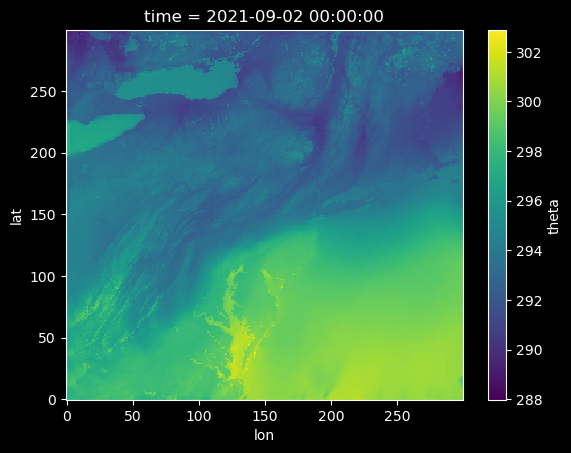

In [12]:
theta2m_all.sel(time="2021-09-02 00:00:00").mean(dim="run").plot()

In [14]:
wofs_all[0].temperature_500

<xarray.DataArray 'temperature_500' (time: 73, ne: 18, lat: 300, lon: 300)> Size: 946MB
dask.array<concatenate, shape=(73, 18, 300, 300), dtype=float64, chunksize=(1, 18, 300, 300), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 584B 2021-09-01 20:00:00 ... 2021-09-02 02:00:00
Dimensions without coordinates: ne, lat, lon
Attributes:
    long_name:                                          500-hPa temperature
    units:                                              deg C
    level:                                              T500
    init_time:                                          20210901_200000
    valid_time:                                         20210901_200000
    init_time_ut:                                       1630526400
    valid_time_ut:                                      1630526400
    QuantizeGranularBitGroomNumberOfSignificantDigits:  4